### 라이브러리 불러오기

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'retina'

plt.rcParams['font.family'] = 'Malgun Gothic'

## 리뷰 심층분석 시작(문제정의를 위한, 심화 EDA)

In [3]:
# 데이터 로드
master_orders = pd.read_csv('../data/master/master_orders.csv')

In [10]:
# 1. 리뷰 분포
master_orders['review_score'].value_counts(normalize=True)

review_score
5.0    0.591489
4.0    0.197145
1.0    0.097921
3.0    0.082939
2.0    0.030505
Name: proportion, dtype: float64

In [6]:
# 2. 지연 vs 리뷰
master_orders.groupby('is_delayed')['review_score'].mean()

is_delayed
0    4.293529
1    2.563000
Name: review_score, dtype: float64

In [12]:
# 기술 통계
print(master_orders['review_score'].describe())

count    94443.000000
mean         4.153775
std          1.286123
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review_score, dtype: float64


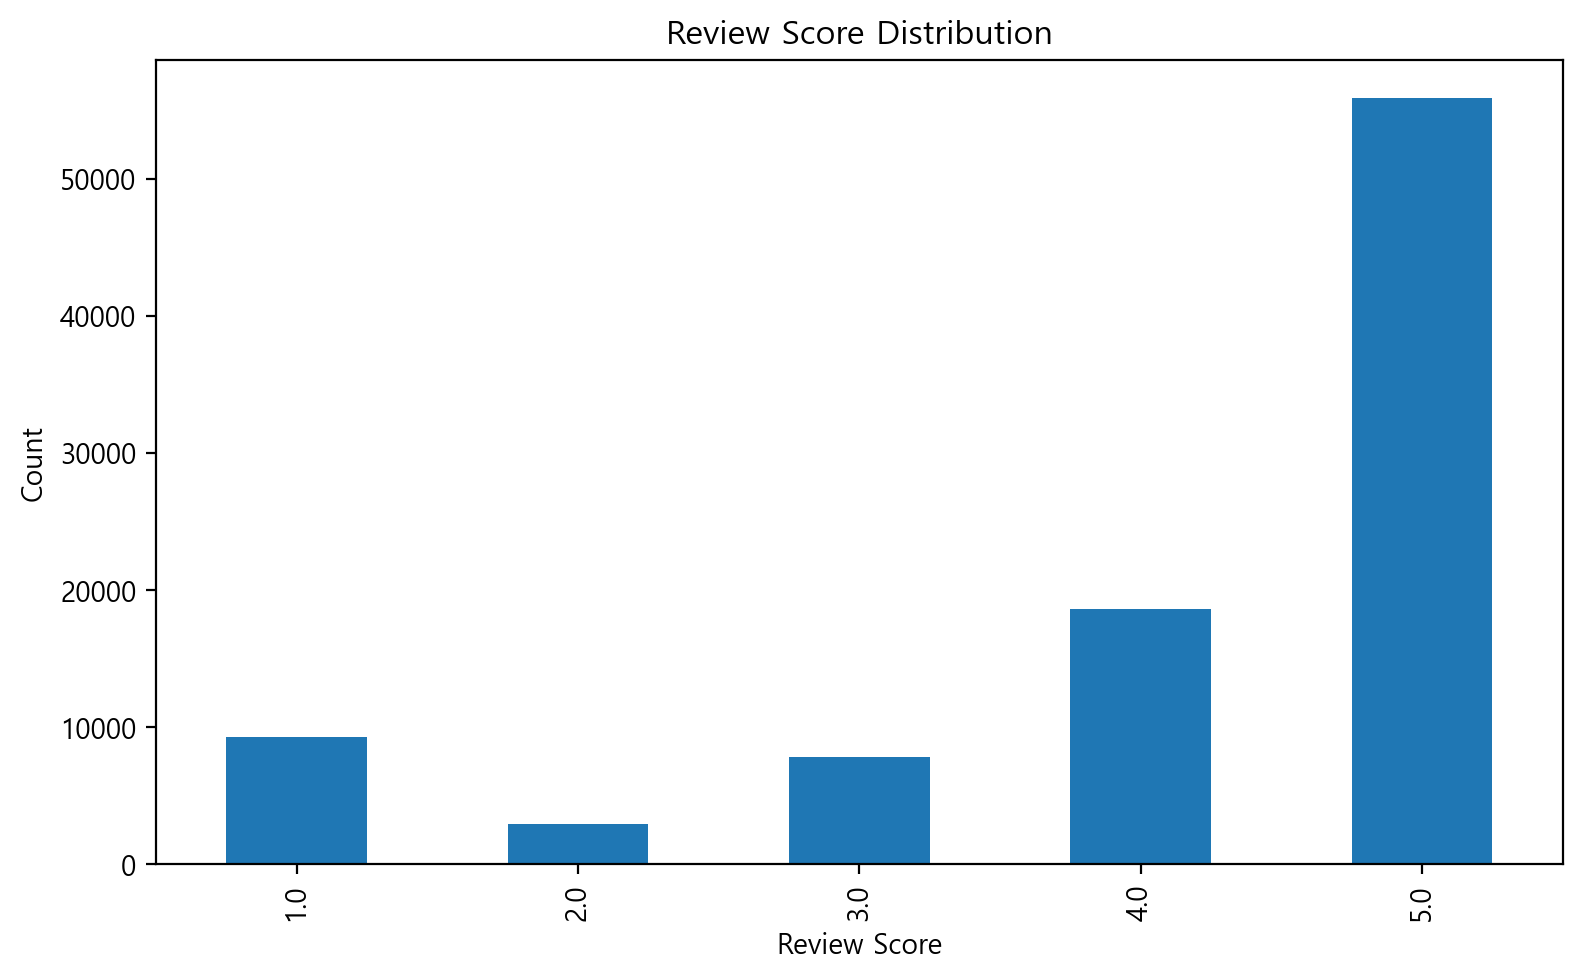

In [15]:
import matplotlib.pyplot as plt

# 리뷰 분포 막대그래프
fig, ax = plt.subplots(figsize=(8, 5))
master_orders['review_score'].value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_xlabel('Review Score')
ax.set_ylabel('Count')
ax.set_title('Review Score Distribution')
plt.tight_layout()
plt.show()

In [16]:
# 양극화 지수 (5점 + 1점 비율)
score_dist = master_orders['review_score'].value_counts(normalize=True)
five_star = score_dist.get(5, 0) * 100
one_star = score_dist.get(1, 0) * 100
polarization = five_star + one_star

print(f"5점 비율: {five_star:.1f}%")
print(f"1점 비율: {one_star:.1f}%")
print(f"양극화 지수: {polarization:.1f}%")

5점 비율: 59.1%
1점 비율: 9.8%
양극화 지수: 68.9%


In [ ]:
# 리뷰_제목 Join을 위함
order_reviews = pd.read_csv('../data/processed_v2/olist_order_reviews_dataset.csv')

In [20]:
# 1점 리뷰 + 텍스트 정보 조인
one_star_orders = master_orders[master_orders['review_score'] == 1][['order_id']]

one_star_with_text = one_star_orders.merge(
    order_reviews[['order_id', 'review_comment_title', 'review_comment_message']],
    on='order_id',
    how='left'
)

print(f"1점 리뷰: {len(one_star_with_text):,}건")
print(f"title 있음: {one_star_with_text['review_comment_title'].notna().sum():,}건")
print(f"message 있음: {one_star_with_text['review_comment_message'].notna().sum():,}건")

1점 리뷰: 9,248건
title 있음: 1,549건
message 있음: 7,169건


In [23]:
order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98673 entries, 0 to 98672
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                98673 non-null  object
 1   order_id                 98673 non-null  object
 2   review_score             98673 non-null  int64 
 3   review_comment_title     11552 non-null  object
 4   review_comment_message   40774 non-null  object
 5   review_creation_date     98673 non-null  object
 6   review_answer_timestamp  98673 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [25]:
# 점수별 텍스트 현황
review_with_text = master_orders[['order_id', 'review_score']].merge(
    order_reviews[['order_id', 'review_comment_title', 'review_comment_message']],
    on='order_id',
    how='left'
)

text_stats = review_with_text.groupby('review_score').agg(
    total=('order_id', 'count'),
    title_exists=('review_comment_title', lambda x: x.notna().sum()),
    message_exists=('review_comment_message', lambda x: x.notna().sum())
)

text_stats['title_rate'] = (text_stats['title_exists'] / text_stats['total'] * 100).round(1)
text_stats['message_rate'] = (text_stats['message_exists'] / text_stats['total'] * 100).round(1)

print(text_stats)

              total  title_exists  message_exists  title_rate  message_rate
review_score                                                               
1.0            9248          1549            7169        16.7          77.5
2.0            2881           420            1952        14.6          67.8
3.0            7833           770            3389         9.8          43.3
4.0           18619          1656            5804         8.9          31.2
5.0           55862          6369           20044        11.4          35.9


In [30]:
# 1점 리뷰 데이터 준비
one_star_df = review_with_text[
    (review_with_text['review_score'] == 1) & 
    (review_with_text['review_comment_message'].notna())
][['order_id', 'review_comment_title', 'review_comment_message']].copy()

one_star_df

,order_id,review_comment_title,review_comment_message
9,e6ce16cb79ec1d90b1da9085a6118aeb,NaN,Aguardando retorno da loja
24,acce194856392f074dbf9dada14d8d82,NÃO RECOMENDO!!!!,Até o momento não recebi o produto Protetor De...
29,1790eea0b567cf50911c057cf20f90f9,Enganadores,Foi entregue um produto divergente do que eu h...
39,6ea2f835b4556291ffdc53fa0b3b95e8,NaN,"Inicialmente, na data da compra o produto era ..."
42,6ebaec694d7025e2ad4a05dba887c032,NaN,A cuba veio quebrada. Como efetuo barroca?
...,...,...,...
95040,0fa1fab1d7c1211c824596ed5e111e3c,NaN,"Nao volto a comprar com esta loja , demorando ..."
95045,41d74f5b8f1fb05bdec674cbba8f720f,NaN,Não gostei imaginei que era uma cortina de tec...
95064,38e9133ce29f6bbe35aed9c3863dce01,NaN,nao recebi o produto que ja paguei ! nao recom...
95066,d692ef54145c9cb3322ec2e5508aa3f4,NaN,"Prateleiras com cantos vivo, colunas nao encai..."


In [31]:
one_star_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7169 entries, 9 to 95073
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   order_id                7169 non-null   object
 1   review_comment_title    1483 non-null   object
 2   review_comment_message  7169 non-null   object
dtypes: object(3)
memory usage: 224.0+ KB


In [ ]:
from googletrans import Translator
import time
import pandas as pd
import os

# 1. 저장 경로 확인 및 생성 (폴더가 없으면 에러 방지)
save_dir = '../data/review_ko'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 1점 리뷰 데이터 준비
one_star_df = review_with_text[
    (review_with_text['review_score'] == 1) & 
    (review_with_text['review_comment_message'].notna())
][['order_id', 'review_comment_title', 'review_comment_message']].copy()

print(f"번역 대상: {len(one_star_df):,}건")

# 번역 설정
translator = Translator()
translated_messages = []
translated_titles = []

# 번역 실행
for i, row in one_star_df.iterrows():
    try:
        # --- [핵심 수정] 한 회차의 번역 결과를 임시 변수에 담습니다 ---
        curr_msg = None
        curr_title = None

        # 1) 메세지 번역
        msg_result = translator.translate(row['review_comment_message'], src='pt', dest='ko')
        curr_msg = msg_result.text
        
        # 2) 제목 번역 (있으면)
        if pd.notna(row['review_comment_title']) and str(row['review_comment_title']).strip() != "":
            title_result = translator.translate(row['review_comment_title'], src='pt', dest='ko')
            curr_title = title_result.text
        else:
            curr_title = None
        
        # --- [핵심 수정] 둘 다 성공적으로 번역(또는 처리)되었을 때만 리스트에 추가합니다 ---
        translated_messages.append(curr_msg)
        translated_titles.append(curr_title)
        
        # 진행 상황 출력
        if len(translated_messages) % 100 == 0:
            print(f"진행: {len(translated_messages):,} / {len(one_star_df):,}")
        
        time.sleep(0.5) # 차단 방지
        
    except Exception as e:
        # 에러 발생 시 현재까지 성공한 데이터만이라도 보존하기 위해 루프를 나갑니다.
        print(f"\n중단됨 (에러 발생 혹은 API 차단): {e}")
        print(f"현재까지 완료된 건수: {len(translated_messages)}건")
        break

# 결과 전처리: 성공한 개수만큼만 데이터프레임을 자릅니다.
# 두 리스트 중 더 짧은 쪽에 맞추어 원본 데이터를 자릅니다 (보통 개수는 같을 것입니다).
min_len = min(len(translated_messages), len(translated_titles))
final_df = one_star_df.iloc[:min_len].copy()

# 결과 컬럼 추가
final_df['message_ko'] = translated_messages[:min_len]
final_df['title_ko'] = translated_titles[:min_len]

print(f"\n최종 완료: {len(final_df):,}건")

# CSV 저장 (전달해주신 경로 수정 버전)
save_path = os.path.join(save_dir, 'one_star_reviews_translated.csv')
final_df.to_csv(save_path, index=False, encoding='utf-8-sig')
print(f"저장 완료: {save_path}")

진행: 500 / 7,169
